In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:02<00:00, 69.9MB/s]
100% 149M/149M [00:02<00:00, 66.7MB/s]


In [ ]:
! unzip "/content/brain-tumor-mri-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

### Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,InputLayer
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras.layers as L

### Reading Data

In [ ]:
def read_images(path):
    images = []
    labels = []
    dirs = ['notumor','glioma','meningioma','pituitary']
    for i,dir_ in enumerate(dirs):
        path_ = f"{path}/{dir_}"
        for k in os.listdir(path_):
            images.append(f"{path_}/{k}")
            labels.append(dir_)
    return pd.concat([pd.Series(images,name='Image'),pd.Series(labels,name='Class')],axis=1)

In [ ]:
ts_df = read_images(r"C:/Users/muham/Downloads/brain-tumor/Training") #/kaggle/input/brain-tumor-mri-dataset/Training For Kaggle
test_df = read_images(r"C:/Users/muham/Downloads/brain-tumor/Testing") #/kaggle/input/brain-tumor-mri-dataset/Testing For Kaggle

In [ ]:
train_df, valid_df = train_test_split(ts_df,  train_size= 0.8, shuffle= True, random_state= 42)

### EDA

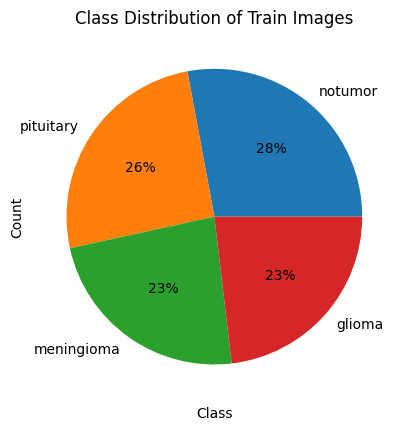

In [ ]:
pd.DataFrame(ts_df,columns=["Class"])["Class"].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Class Distribution of Train Images")
plt.show()

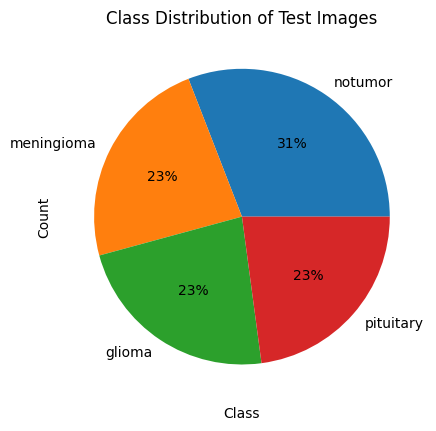

In [ ]:
pd.DataFrame(test_df,columns=["Class"])["Class"].value_counts().plot(kind='pie',autopct='%1.0f%%')
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Class Distribution of Test Images")
plt.show()

### Data Preparation

In [ ]:
img_size =  (256,256)
batch_size = 32

In [34]:
tr_gen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'Image', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'Image', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'Image', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


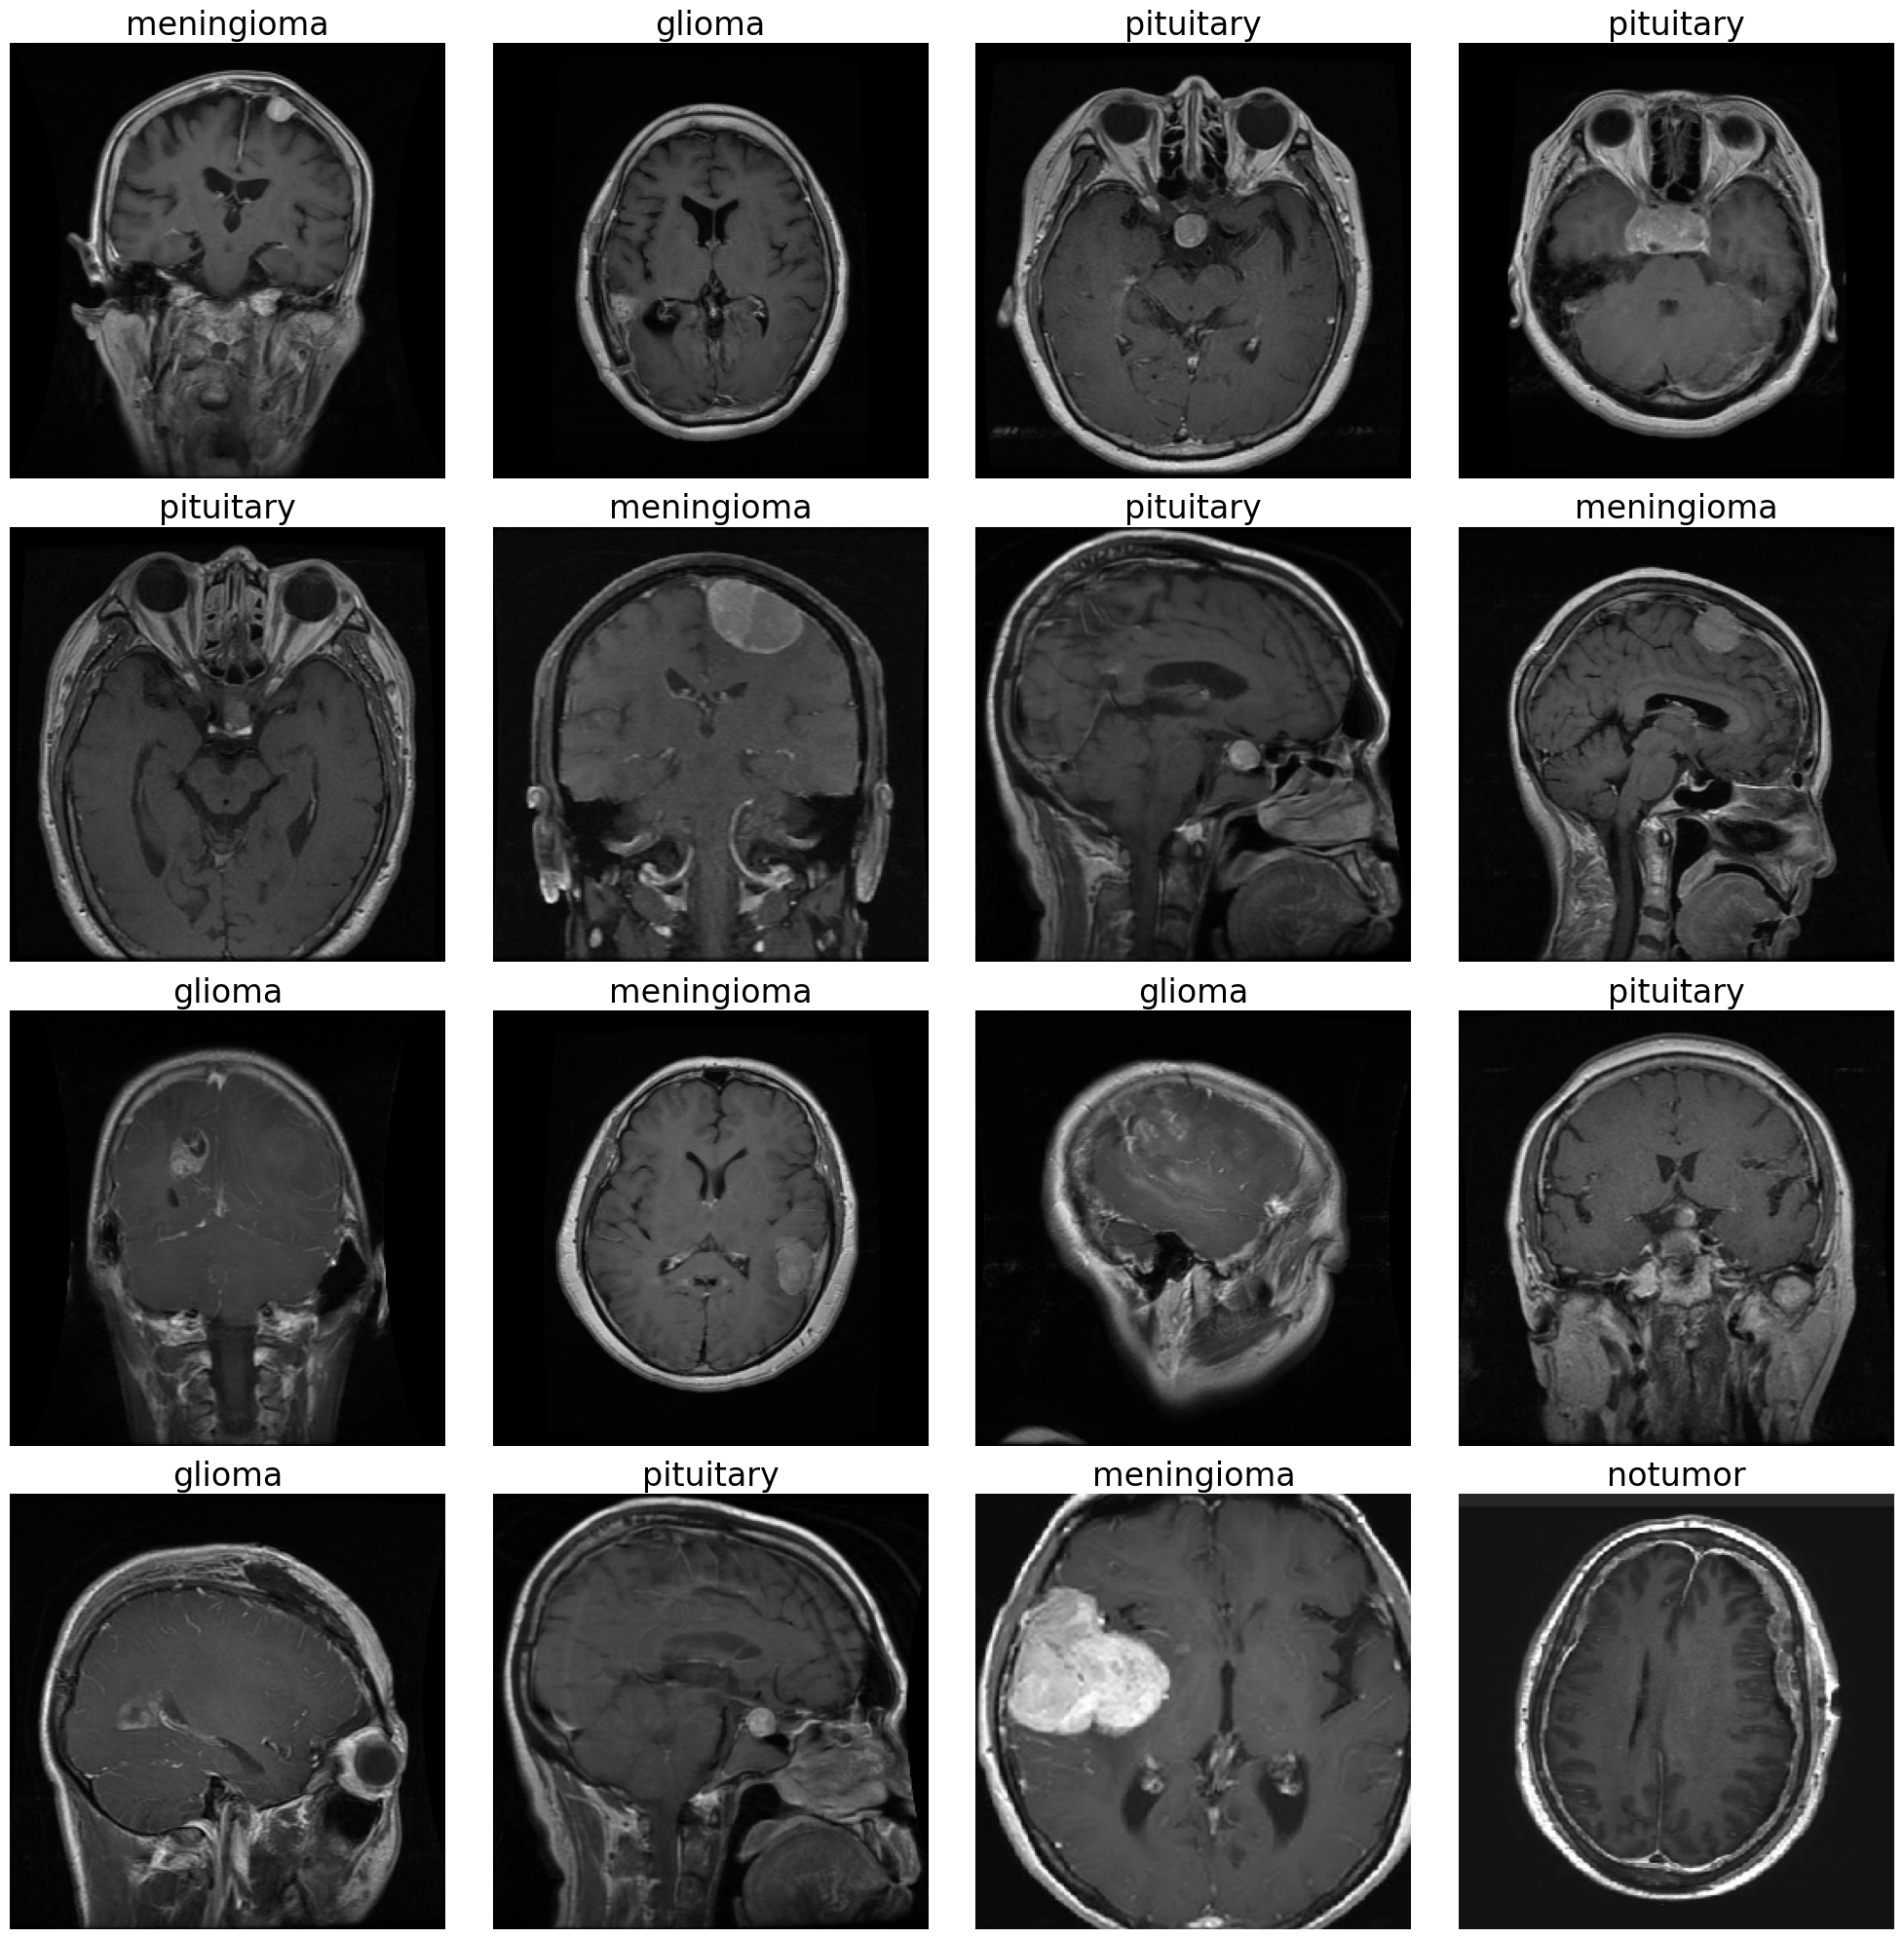

In [35]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 24)
    plt.axis('off')
plt.tight_layout()
plt.show()

### ANN

In [ ]:
model = Sequential()
model.add(InputLayer(shape=(256,256,3)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,170,212 (96.02 MB)

 Trainable params: 25,170,212 (96.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_gen,validation_data= valid_gen, shuffle= False,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step - accuracy: 0.4699 - loss: 1126.4657
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 318ms/step - accuracy: 0.7015 - loss: 151.1419
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 318ms/step - accuracy: 0.7292 - loss: 123.5437
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.7700 - loss: 94.5681
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.7776 - loss: 69.3528
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.8267 - loss: 43.5724
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.7808 - loss: 68.2220
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8681 - loss: 25.3598
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.8415 - loss: 30.8502
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 330ms/step - accuracy: 0.8458 - loss: 29.6232


In [ ]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred,axis=1)
y_true = test_gen.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [ ]:
print(classification_report(y_true,y_pred,zero_division=0,target_names=classes))

              precision    recall  f1-score   support

           0       0.89      0.37      0.52       300
           1       0.36      0.96      0.53       306
           2       0.97      0.60      0.74       405
           3       0.99      0.42      0.59       300

    accuracy                           0.59      1311
   macro avg       0.80      0.59      0.59      1311
weighted avg       0.81      0.59      0.61      1311



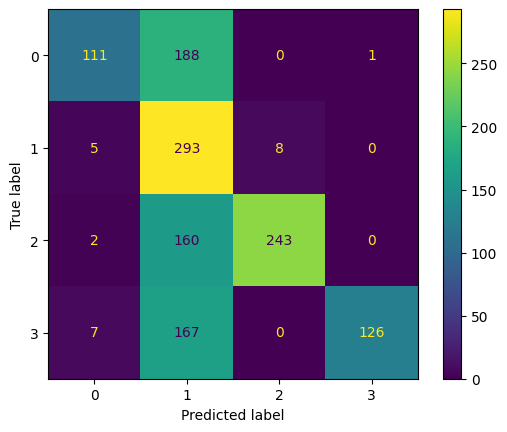

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=classes)

cmd.plot()
plt.show()

### CNN

In [ ]:
model = Sequential([
    InputLayer(shape=(256,256,3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,518,084 (120.23 MB)

 Trainable params: 31,518,084 (120.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_gen,validation_data= valid_gen, shuffle= False,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6509 - loss: 77.9189
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9433 - loss: 0.1827
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.9856 - loss: 0.0478
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9906 - loss: 0.0349
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9830 - loss: 0.0607
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9933 - loss: 0.0232
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9844 - loss: 0.0774
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.9950 - loss: 0.0214
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9923 - loss: 0.0285
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9951 - loss: 0.0149


In [ ]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred,axis=1)
y_true = test_gen.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 570ms/step


In [ ]:
print(classification_report(y_true,y_pred,zero_division=0,target_names=classes))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       300
           1       0.87      0.92      0.89       306
           2       0.98      1.00      0.99       405
           3       0.95      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



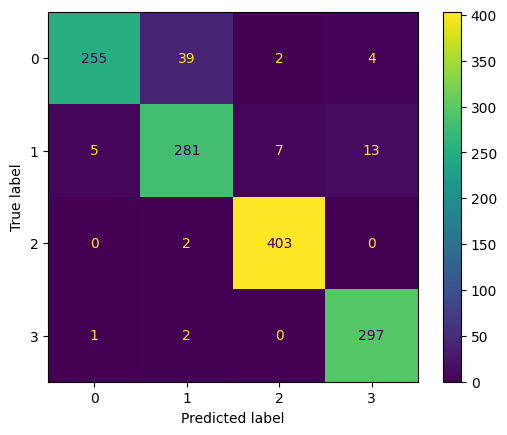

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=classes)

cmd.plot()
plt.show()

### Transfer Learning using VGG19 Imagenet

In [ ]:
model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential()
for layer in model_vgg19.layers:
    model.add(layer)

In [ ]:
for i in model.layers:
   i.trainable = False

In [ ]:
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_gen,validation_data= valid_gen, shuffle= False,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2685s 15s/step - accuracy: 0.7620 - loss: 8.8179
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2690s 15s/step - accuracy: 0.9556 - loss: 0.2623
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2686s 15s/step - accuracy: 0.9722 - loss: 0.1397
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2701s 15s/step - accuracy: 0.9917 - loss: 0.0273
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2714s 15s/step - accuracy: 0.9899 - loss: 0.0447
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2655s 15s/step - accuracy: 0.9905 - loss: 0.0451
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2643s 15s/step - accuracy: 0.9867 - loss: 0.0814
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2644s 15s/step - accuracy: 0.9900 - loss: 0.0372
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2621s 15s/step - accuracy: 0.9816 - loss: 0.0848
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2667s 15s/step - accuracy: 0.9913 - loss: 0.0524


In [ ]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred,axis=1)
y_true = test_gen.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 597s 15s/step


In [ ]:
print(classification_report(y_true,y_pred,zero_division=0,target_names=classes))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       300
           1       0.91      0.95      0.93       306
           2       1.00      1.00      1.00       405
           3       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



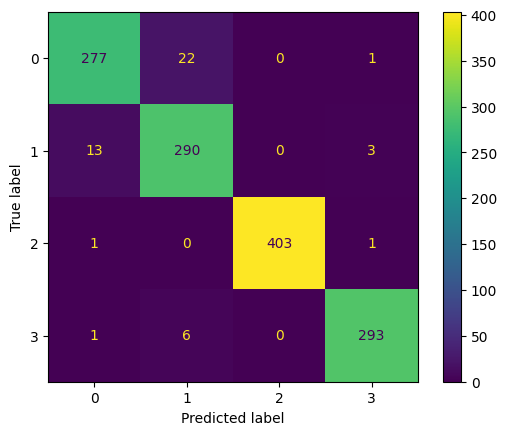

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=classes)

cmd.plot()
plt.show()

### Vision Transformer

In [69]:
num_epochs = 10
n_classes=4
image_size = 256
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [56, 28]  # Size of the dense layers of the final classifier

In [70]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = L.Dense(units, activation = tf.nn.relu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [99]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [100]:
class PatchEncoder(L.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units = projection_dim)
        self.position_embedding = L.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [101]:
def vision_transformer():
    inputs = L.Input(shape = (image_size, image_size, 3))
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        attention_output = L.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x1, x1)
        x2 = L.Add()([attention_output, encoded_patches])
        x3 = L.LayerNormalization(epsilon = 1e-6)(x2)
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)
        encoded_patches = L.Add()([x3, x2])

    representation = L.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    logits = L.Dense(n_classes)(features)
    model = tf.keras.Model(inputs = inputs, outputs = logits)

    return model

In [102]:
model = vision_transformer()
model.compile(optimizer = 'adam',
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

(None, 256, 256, 3)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 patches_11 (Patches)        (None, None, 192)            0         ['input_12[0][0]']            
                                                                                                  
 patch_encoder_11 (PatchEnc  (None, 1024, 64)             77888     ['patches_11[0][0]']          
 oder)                                                                                            
                                                                                                  
 layer_normalization_55 (La  (None, 1024, 64)             128       ['p

In [103]:
model.fit(train_gen,validation_data= valid_gen, shuffle= False,epochs=10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.6009 - loss: 87.9189
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.7433 - loss: 0.1827
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8056 - loss: 0.4780
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.8506 - loss: 0.3490
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.8730 - loss: 0.6070
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.8943 - loss: 0.2320
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8944 - loss: 0.7740
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.8950 - loss: 0.2140
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.8923 - loss: 0.2850
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.8951 - loss: 0.1490


In [ ]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred,axis=1)
y_true = test_gen.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 597s 15s/step


In [ ]:
print(classification_report(y_true,y_pred,zero_division=0,target_names=labels))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       300
           1       0.80      0.87      0.84       306
           2       0.85      0.88      0.86       405
           3       0.90      0.83      0.87       300

    accuracy                           0.85      1311
   macro avg       0.84      0.82      0.83      1311
weighted avg       0.83      0.81      0.83      1311



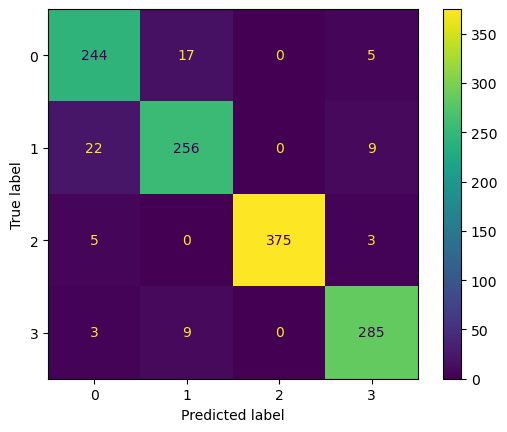

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cmd = ConfusionMatrixDisplay(cm,display_labels=labels)

cmd.plot()
plt.show()
